## What is this competition all about?

* Given seismic signals we are asked to predict the time until the onset of laboratory earthquakes.
* The training data is a single sequence of signal and seems to come from one experiment alone.
* In contrast the test data consists of several different sequences, called segments, that may correspond to different experiments. The regular pattern we might find in the train set does not match those of the test segments. 
* For each test data segment with its corresponding seg_id we are asked to predict it's single time until the lab earthquake takes place.

## Loading packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import HTML

from os import listdir
print(listdir("../input"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test', 'train.csv']


## What is an earthquake in the lab?

Currently I don't know how an earthquake in the laboratory works and as I like to know I googled around and found this nice video that shows how such a lab looks like. If you like, feel free to take a look at it. I'm still on my journey to understand the problem. 

In [2]:
HTML('<iframe width="800" height="400" src="https://www.youtube.com/embed/m_dBwwDJ4uo" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

In the end we can see that the probes that are used are put under some kind of **normal pressure but there is a shear stress working on it as well**. Then, after some time, the probe splits. If you take a look at the additional material given, you can see that we have: 

### 3 kind of plates

* 2 plates left and right that are under normal pressure: Forces are acting with 90 degree on the plate, pushing the two plates together. 
* In the middle we find a third plate which is separated by some granular material. This plate moves downwards with constant velocity. 

I'm not sure if I understand this right, but it seems that this granular material is the "rock" that can split and load again to produce this kind of lab earthquakes in repetitive cycles. Even though the train set contains continuous data it contains several such splits (earthquakes).

## Let's get familiar with the data!

### Training data

The total size of the train data is almost 9 GB and we don't want to wait too long just for a first impression, let's load only some rows: 

In [3]:
train = pd.read_csv("../input/train.csv", nrows=10000000,
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
train.head(5)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


We can see two columns: Acoustic data and time_to_failure. The further is the seismic singal and the latter corresponds to the time until the laboratory earthquake takes place. Ok, personally I like to rename the columns as typing "acoustic" every time is likely for me to produce errors:

In [4]:
train.rename({"acoustic_data": "signal", "time_to_failure": "quaketime"}, axis="columns", inplace=True)
train.head(5)

,signal,quaketime
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


We can see that the quaketime of these first rows seems to be always the same. But is this really true?

In [5]:
for n in range(5):
    print(train.quaketime.values[n])

1.4690999832
1.4690999821000001
1.4690999809999998
1.4690999799000002
1.4690999787999999


Aha! We can see that they are not the same and that pandas has rounded them off. And we can see that the time seems to decrease. Let's plot the time to get more familiar with this pattern:

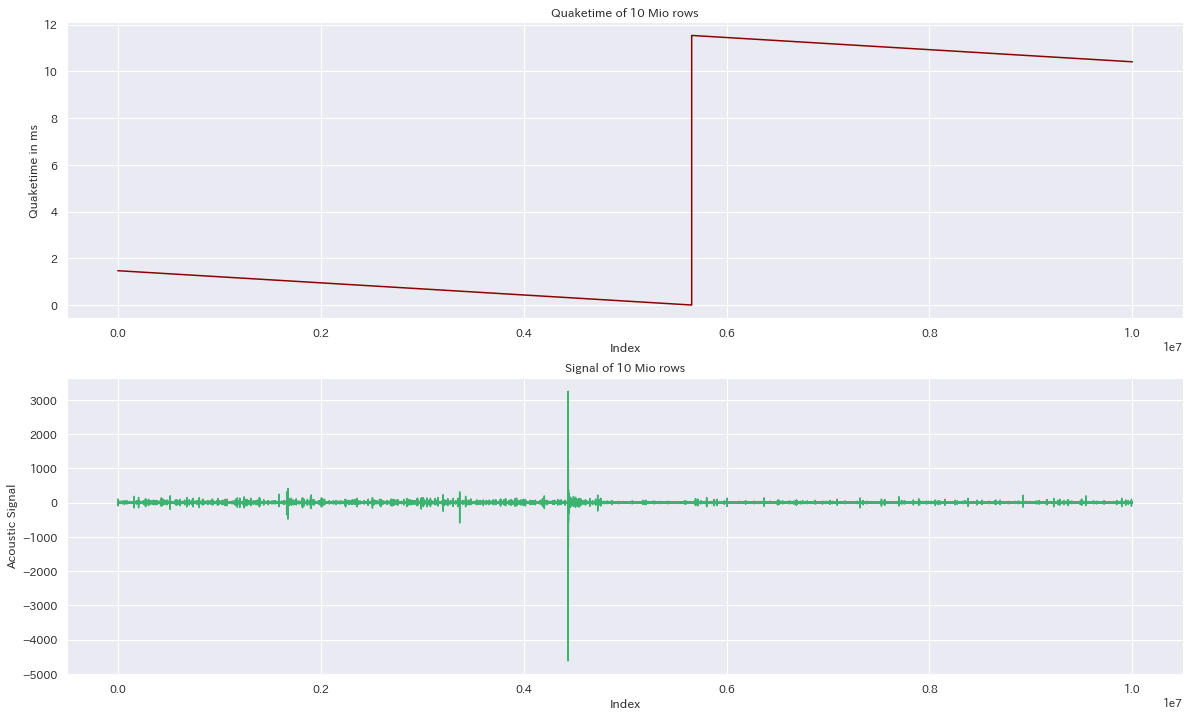

In [6]:
fig, ax = plt.subplots(2,1, figsize=(20,12))
ax[0].plot(train.index.values, train.quaketime.values, c="darkred")
ax[0].set_title("Quaketime of 10 Mio rows")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Quaketime in ms");
ax[1].plot(train.index.values, train.signal.values, c="mediumseagreen")
ax[1].set_title("Signal of 10 Mio rows")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Acoustic Signal");

### Take-Away

* We can see only one time in 10 Mio rows when quaketime goes to 0. This is a timepoint where an earthquake in the lab occurs. 
* There are many small oscillations until a heavy peak of the signal occurs. Then it takes some time with smaller oscillations and the earthquake occurs.


If we take a look at the first 50000 indizes we can see that there is a second pattern of quaketime that may has something to do with the resolution of the experimental equipment:

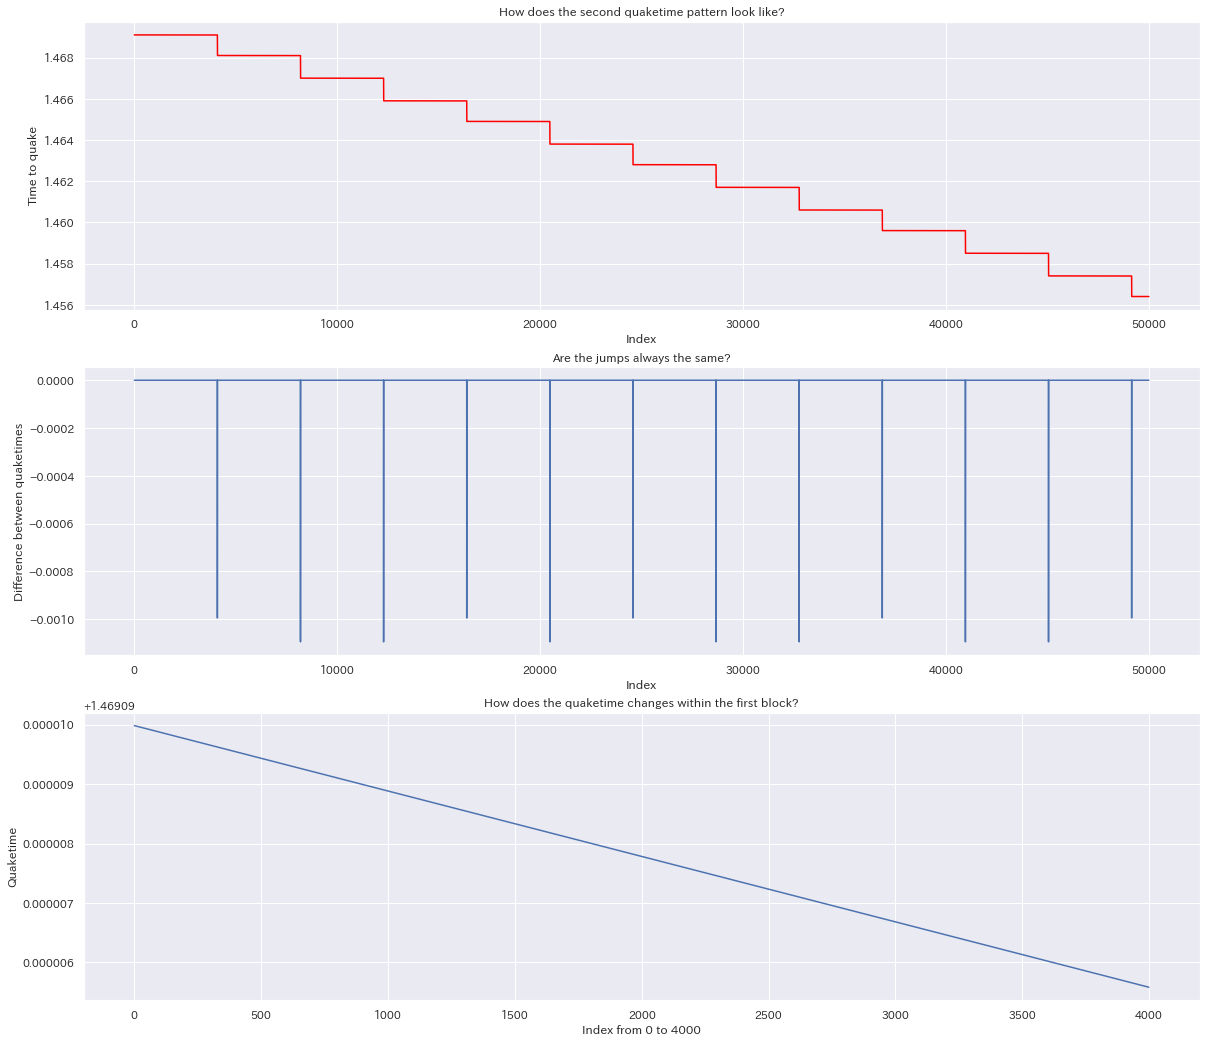

In [7]:
fig, ax = plt.subplots(3,1,figsize=(20,18))
ax[0].plot(train.index.values[0:50000], train.quaketime.values[0:50000], c="Red")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Time to quake")
ax[0].set_title("How does the second quaketime pattern look like?")
ax[1].plot(train.index.values[0:49999], np.diff(train.quaketime.values[0:50000]))
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Difference between quaketimes")
ax[1].set_title("Are the jumps always the same?")
ax[2].plot(train.index.values[0:4000], train.quaketime.values[0:4000])
ax[2].set_xlabel("Index from 0 to 4000")
ax[2].set_ylabel("Quaketime")
ax[2].set_title("How does the quaketime changes within the first block?");

### Take-Away

Very interesting!

* The first plot shows that the quaketime seems to stay almost constant up to index 4000. Then a steep decrease occurs. Afterwards this kind of pattern is repeated.
* The second plot reveals that the second jump of the quaketime is larger than the first.
* The third plot shows that the quaketime within such a "constant" block is not really constant but linear decreasing even though with very small numbers.

### First conclusion

Thank you to @pete **who pointet out that there are 16 earthquakes in the train set and that they really occur when quaketime goes to 0**. It's still interesting why we have **several blocks and jumps of quaketime on low resolution** where the time decreases linear with a very small stepsize.

Currently I'm not sure why these jumps between our target quaketime occur between values with only small scaled differences.  **What do you think? Let's me know if you like in the commets ;-) **

Ok, I feel more familiar with the train data right now. Let's turn to the test data before switching to more explorations.

### Test data

We can find multiple segments of sequences in the test folder. Let's peek at their names:

In [8]:
test_path = "../input/test/"

In [9]:
test_files = listdir("../input/test")
print(test_files[0:5])

['seg_00030f.csv', 'seg_0012b5.csv', 'seg_00184e.csv', 'seg_003339.csv', 'seg_0042cc.csv']


How many segments do we have?

In [10]:
len(test_files)

2624

Does this match with the number of seg_ids in the sample submission?

In [11]:
sample_submission = pd.read_csv("../input/sample_submission.csv")
sample_submission.head(2)

,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0


In [12]:
len(sample_submission.seg_id.values)

2624

Ok. How does the signal of the test data look like?

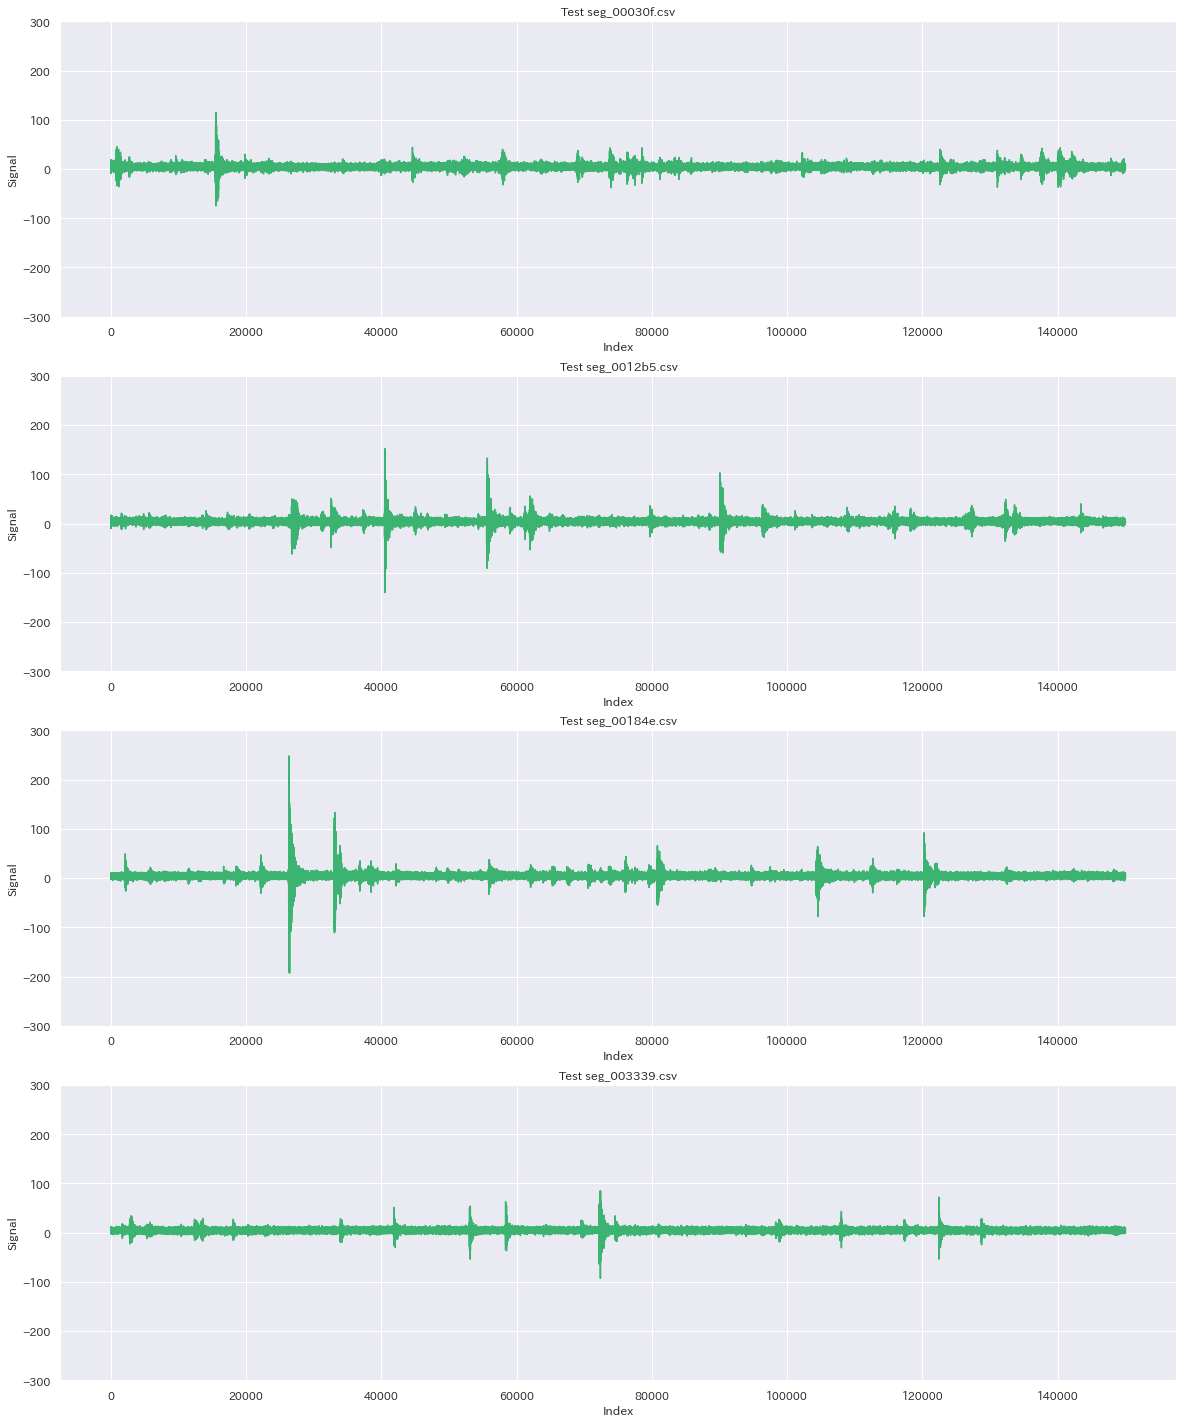

In [13]:
fig, ax = plt.subplots(4,1, figsize=(20,25))

for n in range(4):
    seg = pd.read_csv(test_path  + test_files[n])
    ax[n].plot(seg.acoustic_data.values, c="mediumseagreen")
    ax[n].set_xlabel("Index")
    ax[n].set_ylabel("Signal")
    ax[n].set_ylim([-300, 300])
    ax[n].set_title("Test {}".format(test_files[n]));

### Take-Away

* These test segment examples differ a lot in the occurences of small peaks that seem to be similar to those in the train data before and after the heavy signal peak that occured some time before the lab earthquake took place. 
* They probably came from the same experiment but do neither form a continuous signal nor directly follow after the train data. 

## A question collection

Even though there is only one signal feature and one target column, there is so much we need to understand and explore. Before we add more and more features, it's probably better to work with what is given so far. I'm afraid of feeling puzzled too fast. ;-) And to prevent that feeling even further, I like to collect the questions that draw circles in my mind:

### Questions for the train set

* Why do we have this low resolution jumps and why are they different? Is there some periodicity that may correlate with the signal? Would it be helpful to reconstruct that for test segments?
* Why do we only have 16 earthquakes and such a high resolution of signal inbetween?


### Questions for the test set

* Are all segments of the test set of the same length?
* Are they similar in their distributions or in the strength and time period between strong peaks?
* Can we find some groups of similar test set segments?


## A jump into train explorations

In [14]:
train.describe()

,signal,quaketime
count,1.000000e+07,1.000000e+07
mean,4.502072e+00,5.183598e+00
std,1.780707e+01,5.091286e+00
min,-4.621000e+03,7.954798e-04
25%,2.000000e+00,6.498971e-01
50%,4.000000e+00,1.298899e+00
75%,7.000000e+00,1.089170e+01
max,3.252000e+03,1.154080e+01


* We can see that the mean is shifted towards higher values due to the earthquake. In addition we can see that the 25% up to 75% quartils are looking very discrete.
* Looking at the quaketime we can't say much about it.

### The train signal distribution

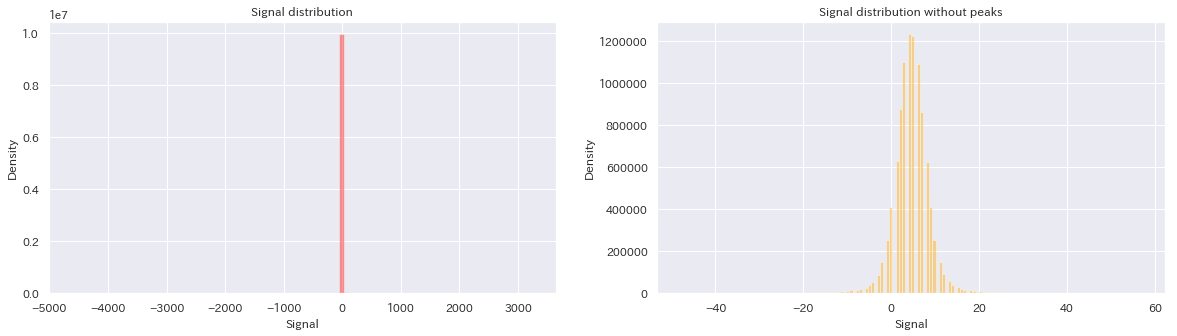

In [15]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(train.signal.values, ax=ax[0], color="Red", bins=100, kde=False)
ax[0].set_xlabel("Signal")
ax[0].set_ylabel("Density")
ax[0].set_title("Signal distribution")

low = train.signal.mean() - 3 * train.signal.std()
high = train.signal.mean() + 3 * train.signal.std() 
sns.distplot(train.loc[(train.signal >= low) & (train.signal <= high), "signal"].values,
             ax=ax[1],
             color="Orange",
             bins=150, kde=False)
ax[1].set_xlabel("Signal")
ax[1].set_ylabel("Density")
ax[1].set_title("Signal distribution without peaks");

### Take-Away

* In the first plot the we can see that **the earthquake causes very high outlier values**. This way we can't say much about the signal distribution close to zero. 
* The second plot shows the signal at the median and mean around 4. We can see that it **looks very gaussian and balanced. It seems that the signal is somehow discrete.**

### The stepsize

By computing the difference between to quaketimes we obtain some kind of stepsize that is probably equal within blocks and can show us the jump strength between different quaketimes. The following code computes differences first and drops the last row of train such that we can add the stepsize to the data. I think we won't loose fruitful information this way.

In [16]:
stepsize = np.diff(train.quaketime)
train = train.drop(train.index[len(train)-1])
train["stepsize"] = stepsize
train.head(5)

,signal,quaketime,stepsize
0,12,1.4691,-1.100000e-09
1,6,1.4691,-1.100000e-09
2,8,1.4691,-1.100000e-09
3,5,1.4691,-1.100000e-09
4,8,1.4691,-1.100000e-09


In [17]:
train.stepsize = train.stepsize.apply(lambda l: np.round(l, 10))

In [18]:
stepsize_counts = train.stepsize.value_counts()
stepsize_counts

-1.100000e-09    5655193
-1.000000e-09    3907598
-2.000000e-09     434767
-1.095496e-03        882
-1.095495e-03        679
-9.954955e-04        497
-9.954950e-04        381
-1.095497e-03          1
 1.154000e+01          1
Name: stepsize, dtype: int64

Still strange! **The stepsize within two quaketimes is often given by either -1, -1,1 or -2 ns**. In addition we have **stepsizes close to -1,0955 ms or -0,9955 ms** :-) Do you see it? It's something centered at -1 ms. As we have one earthquake in train the **heavy stepsize of 11.5 is the step between the earthquake and a new cycle** that goes on until the next earthquake occurs.

## Setting up a validation strategy

Ok, I think that is part is difiicult. In my opinion it does not make sense to split the rows of the train data randomly to obtain validation data. This is temporal data and in the test segments we probably don't have any future values given. In the description you can see that:

> The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

Hmm. What does that mean for us? Let's collect some scenarios:

### Scenario A

* The **cycles in the train data are independent of each other**. 
* If there was already an earthquake **does not change the material** in its fault behaviors. 
* Let's suppose the **test data uses the same experimental setup**. 

If this is true it's not important that we need a second (or multiple) experiment to generate test data. We could only do one experiment and cut out segments to produce different data snippets. As this does not fit well to the description of the data **this scenario is not likely**.

### Scenario B

* The cycles depend on each other. There is temporal correlation of future signals with past ones. 
* The **material changes somehow from cycle to cylce** and perhaps future cycles are clearly different from past ones.
* The **test data** uses the **same experimental setup** but to prevent leakage there were **at least one new experiment** done to produce segments that may depend on each other, e.g some of them may have temporal correlations. 
* To make it more tricky there are **only some snippets given in the test data whereas others are simply dropped**. 

In this case we need a model that is able to capture the temporal dependence of cycles and it should be able to make nice predictions for different cycles. As we need to make predictions for several different cycle-phases it could be fruitful to use some kind of rolling window validation. 

### Scenario C

* The **cylces depend on each other**. There is temporal correlation of future signals with past ones.
* The state of the **material changes from cycle to cycle**.
* The **test data uses experimental setups that are different from the train data generation** process. In the worst case we have multiple different experiments that produce test data. 
* To make it more tricky there are **only some snippets given in the test data whereas others are simply dropped**. 

This is my personal worst case and this would probably cause high differences between scores of validation and test data. 

### How to split now?

To start with this competition **I prefer scenario B** and I haven't done it before but there is a scikit-learn implementation that may help us now. But before we keep going on... there is one more topic that should be considered: **The test set does not contain any earthquakes. Hence it's perhaps not a good idea to include them during training and validation**. In training they would cause extreme target outliers of quaketime. Our model may always try to match its predictions with these targets and this would hinder learning for the relevent parts, for those kind of predictions we need for the test set. 

In [19]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=5)

## Rolling features

I sometimes get stuck in too much details that may not be neccessary or are more fun to explore by yourself. As this is just a starter, I like to continue with some ideas and visualisations that have been used in initial work of Bertrand Rouet-Leduc and the LANL-group. One of the ideas was to use features extracted by a rolling window approach. Let's do the same and make some visualisations what goes on with these features until the first lab earthquake occurs.

### Window size

I don't know in adcance which kind of window size would be an appropriate choice and I think it's an hyperparameter we should try to optimize. But to start, let's try out some different sizes and the mean and standard deviation to select one that may be sufficient to play around:

In [20]:
window_sizes = [10, 50, 100, 1000]
for window in window_sizes:
    train["rolling_mean_" + str(window)] = train.signal.rolling(window=window).mean()
    train["rolling_std_" + str(window)] = train.signal.rolling(window=window).std()

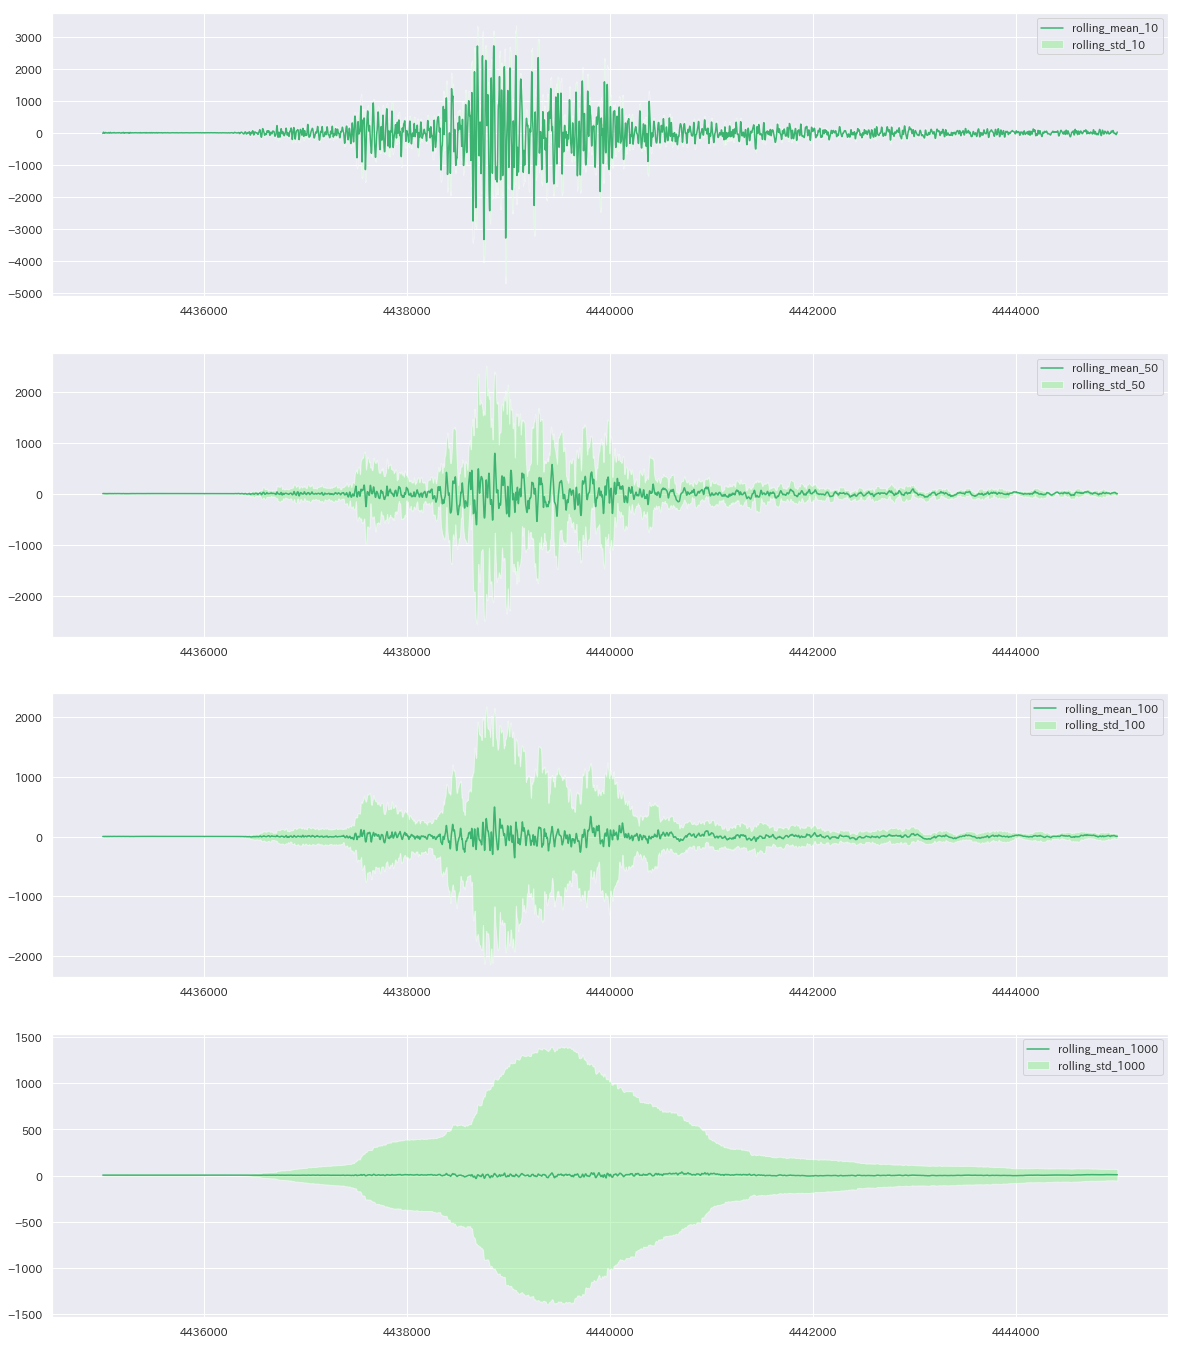

In [21]:
fig, ax = plt.subplots(len(window_sizes),1,figsize=(20,6*len(window_sizes)))

n = 0
for col in train.columns.values:
    if "rolling_" in col:
        if "mean" in col:
            mean_df = train.iloc[4435000:4445000][col]
            ax[n].plot(mean_df, label=col, color="mediumseagreen")
        if "std" in col:
            std = train.iloc[4435000:4445000][col].values
            ax[n].fill_between(mean_df.index.values,
                               mean_df.values-std, mean_df.values+std,
                               facecolor='lightgreen',
                               alpha = 0.5, label=col)
            ax[n].legend()
            n+=1


A window size of 50 looks good enough to cover most fluctuations in sufficient detail without averaging out important signals. 

### Statistical features

Now, that we have found a first choice for the window size, let's compute some basic rolling statistical features:

* mean 
* standard deviation
* 25% quartile
* 50% quartile (median)
* 75% quartile
* interquartile range (75%-25%)
* min
* max
* skewness 
* kurtosis

Just for curiosity let's keep the mean and std for the window sizes we have excluded from above. Perhaps we can see later that these features were more important than the 50-size-window-features. 

In [22]:
train["rolling_q25"] = train.signal.rolling(window=50).quantile(0.25)
train["rolling_q75"] = train.signal.rolling(window=50).quantile(0.75)
train["rolling_q50"] = train.signal.rolling(window=50).quantile(0.5)
train["rolling_iqr"] = train.rolling_q75 - train.rolling_q25
train["rolling_min"] = train.signal.rolling(window=50).min()
train["rolling_max"] = train.signal.rolling(window=50).max()
train["rolling_skew"] = train.signal.rolling(window=50).skew()
train["rolling_kurt"] = train.signal.rolling(window=50).kurt()

## The end ;-) 

I hope my kernel has supported you in getting started with the data and perhaps it has also provided some ideas to try out. If you like it, you can make me happy with a comment and/or an upvote. Thank you! :-)